In [510]:
# Import needed libraries 
import pandas as pd 
import os
from datetime import timedelta
import numpy as np 
from scipy.signal import argrelextrema
import alpaca_trade_api as tradeapi 
import matplotlib.pyplot as plt 
import matplotlib.dates as mpdates
from mplfinance.original_flavor import candlestick_ohlc
from dotenv import load_dotenv

# Ignore any non-critical future warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [511]:
# Load .env file

load_dotenv()

True

In [512]:
# Set Alpaca API key and secret passwords

alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [513]:
# Initiate REST API

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [514]:
# Establish time frame (5 minute)

time_frame = "5min"

# Identify what stock symbol is trading

stock_symbol = "QQQ"

# Identify what start date to begin data analysis
# JAN 27 27 2021 GameStop event (GME)

start_date = pd.Timestamp("2021-01-27", tz="America/New_York").isoformat()

# Identify what end date to finalize data analysis

end_date = pd.Timestamp("2021-1-28", tz="America/New_York").isoformat()

In [515]:
# Call stock data from identified period of time

stock_data = api.get_bars(
    stock_symbol, 
    time_frame, 
    start = start_date, 
    end = end_date
).df

In [516]:
# Displays the information pulled for working through code

stock_data.info()
display(stock_data.head())
display(stock_data.tail())



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 191 entries, 2021-01-27 09:00:00+00:00 to 2021-01-28 00:55:00+00:00
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   close        191 non-null    float64
 1   high         191 non-null    float64
 2   low          191 non-null    float64
 3   trade_count  191 non-null    int64  
 4   open         191 non-null    float64
 5   volume       191 non-null    int64  
 6   vwap         191 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 11.9 KB


,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2021-01-27 09:00:00+00:00,330.42,330.58,329.93,43,329.93,10740,330.213696
2021-01-27 09:05:00+00:00,330.24,330.36,330.24,34,330.36,3193,330.313439
2021-01-27 09:10:00+00:00,330.21,330.24,330.18,14,330.18,1124,330.211967
2021-01-27 09:15:00+00:00,330.26,330.26,330.25,7,330.25,1360,330.254412
2021-01-27 09:20:00+00:00,330.13,330.25,330.13,10,330.23,1271,330.200189


,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2021-01-28 00:35:00+00:00,317.14,317.14,316.87,96,316.87,28863,316.995793
2021-01-28 00:40:00+00:00,317.31,317.34,317.10,108,317.21,15182,317.154442
2021-01-28 00:45:00+00:00,317.29,317.47,317.21,108,317.47,18718,317.298227
2021-01-28 00:50:00+00:00,317.00,317.28,317.00,160,317.28,21358,317.156206
2021-01-28 00:55:00+00:00,317.20,317.24,316.99,133,316.99,21514,317.127020


In [517]:
# Clean up DF keep Open, High, Low, Close, Volume (OHLCV)

stock_data = stock_data.drop(columns=["trade_count", 'vwap'], axis=1)

# Convert inde

stock_data.head()

,close,high,low,open,volume
timestamp,,,,,
2021-01-27 09:00:00+00:00,330.42,330.58,329.93,329.93,10740
2021-01-27 09:05:00+00:00,330.24,330.36,330.24,330.36,3193
2021-01-27 09:10:00+00:00,330.21,330.24,330.18,330.18,1124
2021-01-27 09:15:00+00:00,330.26,330.26,330.25,330.25,1360
2021-01-27 09:20:00+00:00,330.13,330.25,330.13,330.23,1271


In [518]:
# Isolate closing prices to use for plotting stock data
close = stock_data['close']

print(close)

timestamp
2021-01-27 09:00:00+00:00    330.42
2021-01-27 09:05:00+00:00    330.24
2021-01-27 09:10:00+00:00    330.21
2021-01-27 09:15:00+00:00    330.26
2021-01-27 09:20:00+00:00    330.13
                              ...  
2021-01-28 00:35:00+00:00    317.14
2021-01-28 00:40:00+00:00    317.31
2021-01-28 00:45:00+00:00    317.29
2021-01-28 00:50:00+00:00    317.00
2021-01-28 00:55:00+00:00    317.20
Name: close, Length: 191, dtype: float64


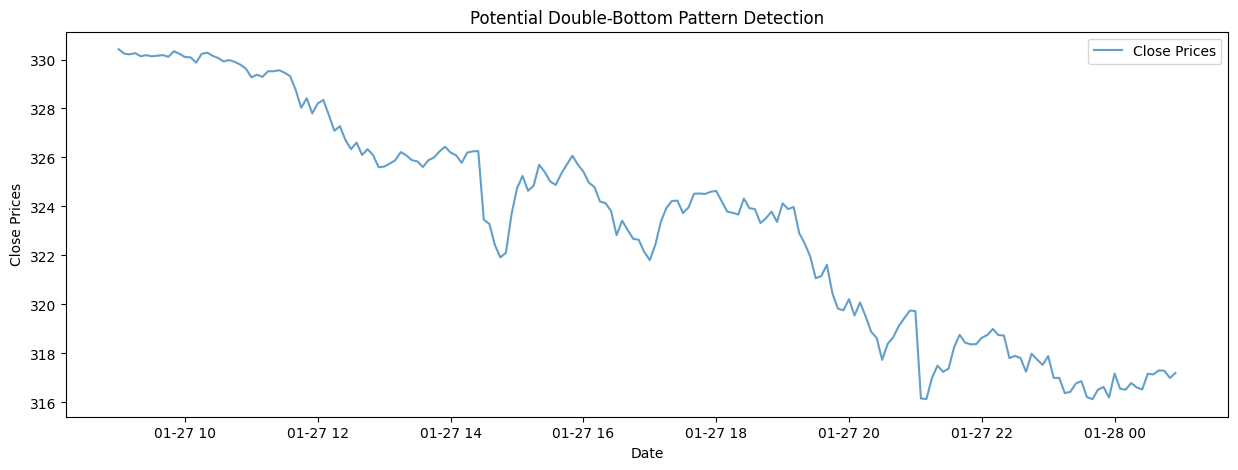

[330.14114761 330.59256443 330.48357678 330.22180269 330.00654792
 329.90877809 329.92728518 330.02659923 330.16118914 330.28962793
 330.3816535  330.42042363 330.40173261 330.33151391 330.22259013
 330.09133644 329.95468995 329.82775456 329.72211308 329.64485718
 329.59827634 329.58010228 329.58418138 329.60143935 329.62100622
 329.63138206 329.62154167 329.58189826 329.5050684  329.38640318
 329.22427134 329.02009876 328.77818417 328.50532315 328.21028146
 327.90316347 327.5947242  327.29567197 327.01600566 326.7644247
 326.54784328 326.37103167 326.23639919 326.14392433 326.09122935
 326.07378853 326.08525306 326.11786974 326.16296684 326.21147813
 326.25447515 326.28367844 326.29192079 326.27353861 326.22467226
 326.14346122 326.03012574 325.88693276 325.71804974 325.52929566
 325.32780376 325.12161465 324.91922184 324.729094   324.55919912
 324.41655565 324.30683403 324.23402955 324.20022382 324.20544748
 324.24765187 324.32279171 324.42501507 324.54695172 324.68008552
 324.815192

/var/folders/sr/78cv2dx14kgdcwtf90634z580000gn/T/ipykernel_49428/3739939631.py:23: RankWarning: Polyfit may be poorly conditioned
  polynomial_coefficients = np.polyfit(x_data, stock_data['close'][:min_length], polynomial_degree)


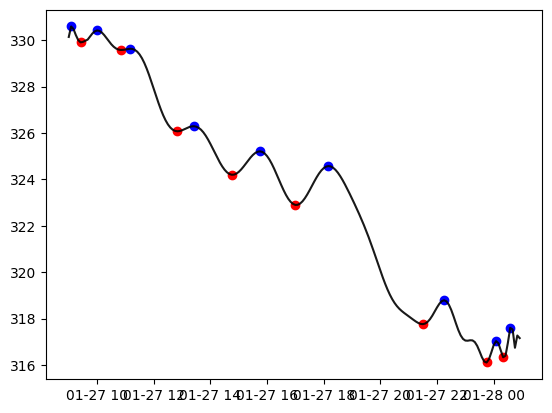

In [538]:
# Find local minima indices using scipy's argrelextrema
#minima_indices = argrelextrema(lows.values, np.less, order=5)[0]

# Plot the stock data and identified minima
plt.figure(figsize=(15, 5))

# Establishes dimensions for x-axis
min_length = min(len(stock_data.index), len(stock_data['close']))

plt.plot(stock_data.index, close, label='Close Prices', alpha=0.7)

#plt.scatter(stock_data.index[minima_indices], lows.iloc[minima_indices], color='red', label='Local Minima')
plt.title('Potential Double-Bottom Pattern Detection')
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.legend()
plt.show()

# Polynomial Fit

x_data = np.arange(min_length)
polynomial_degree = 100  # Adjust as needed
polynomial_coefficients = np.polyfit(x_data, stock_data['close'][:min_length], polynomial_degree)
y_polynomial = np.polyval(polynomial_coefficients, x_data)

print(y_polynomial)

# Identify Local Extrema for polynomial fit data
local_poly_minima = argrelextrema(y_polynomial, np.less, order=5)[0]
local_poly_maxima = argrelextrema(y_polynomial, np.greater, order=5)[0]
# local_poly_minima_df = pd.DataFrame(local_poly_minima)
# local_poly_maxima_df = pd.DataFrame(local_poly_maxima)

# Plot polynomial fit
plt.plot(stock_data.index[:min_length], y_polynomial, '-', markersize=1.0, color='black', alpha=0.9, label='Polynomial Fit')

# Plot red dots at local minima
#plt.scatter(stock_data.index, local_poly_minima, color='red', label='Local Minima')
plt.scatter(stock_data.index[local_poly_minima], y_polynomial[local_poly_minima], color='red', label='Local Minima')
plt.scatter(stock_data.index[local_poly_maxima],y_polynomial[local_poly_maxima], color="blue", label = "Local Maxima")

# # # Define parameters for double-bottom pattern detection
# y_delta = 0.03  # Adjust as needed
# threshold = lows.min() * 1.15

# # Identify potential double-bottom patterns
# # suspected_bottoms = []
# # suspected_tops = []
# # for index in local_poly_minima_df:
# #    avg_price = lows.iloc[max(0, index - 5): min(len(lows), index + 5)].mean()
# #    if lows.iloc[index] < threshold:
# #        suspected_bottoms.append(index)

# # # Plot the identified double-bottom patterns
# # plt.figure(figsize=(15, 5))
# # plt.plot(stock_data.index, lows, label='Low Prices', alpha=0.7)
# # plt.scatter(stock_data.index[suspected_bottoms], lows.iloc[suspected_bottoms], color='green', label='Double Bottoms')
# # plt.axhline(threshold, linestyle='--', color='blue', label='Threshold')
# # plt.title('Identified Double-Bottom Patterns')
# # plt.xlabel('Date')
# # plt.ylabel('Low Prices')
# # plt.legend()
# # plt.show()